In [1]:
from functools import partial

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.distributions import constraints

import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
import pyro.infer.autoguide as ag
from pyro.infer import HMC, NUTS, Predictive, MCMC

import pyro.contrib.easybnn as ezbnn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [2]:
pyro.set_rng_seed(4242)
pyro.enable_validation(True)

In [3]:
# DATA CONSTANTS
TRAIN_SIZE = 20
TRAIN_DELTA = 4
TRAIN_BATCH_SIZE = TRAIN_SIZE // 2
TRAIN_EPOCHS = 10000
TEST_DELTA = 6
TEST_DENSITY = 100
TEST_BATCH_SIZE = 100
NOISE_SCALE = 3

NUM_HIDDEN = 50

# PLOTTING CONFIGURATION
YLIM = 100
PRED_SDS = 3

In [4]:
train_x = 2 * TRAIN_DELTA * (torch.rand(TRAIN_SIZE, 1) - 0.5)
train_y = train_x ** 3 + NOISE_SCALE * torch.randn_like(train_x)

test_x = torch.linspace(-TEST_DELTA, TEST_DELTA, 2 * TEST_DENSITY * TEST_DELTA + 1).unsqueeze(-1)
test_y = test_x ** 3

In [5]:
def plot(pred_mean=None, pred_scale=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.scatter(train_x, train_y)
    ax.plot(test_x, test_y)
    
    if pred_mean is not None:
        ax.plot(test_x.squeeze(-1), pred_mean)
        if pred_scale is not None:
            ax.fill_between(test_x.squeeze(-1),
                            pred_mean - PRED_SDS * pred_scale,
                            pred_mean + PRED_SDS * pred_scale,
                            alpha=0.3)
        
    ax.set_xlim(-TEST_DELTA, TEST_DELTA)
    ax.set_ylim(-YLIM, YLIM)

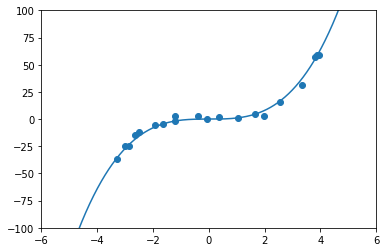

In [6]:
plot()

In [7]:
def make_loader(x, y, batch_size):
    dataset = data.TensorDataset(x, y)
    return data.DataLoader(dataset, batch_size)

In [8]:
def make_net():
    return nn.Sequential(nn.Linear(1, NUM_HIDDEN), nn.ReLU(), nn.Linear(NUM_HIDDEN, 1))

In [9]:
prior = ezbnn.priors.IIDPrior(dist.Normal(0., 1.))
net_guide = ezbnn.guides.ParameterwiseDiagonalNormal

In [29]:
def train(bnn):
    train_loader = make_loader(train_x, train_y, TRAIN_BATCH_SIZE)
    test_loader = make_loader(test_x, test_y, TEST_BATCH_SIZE)
    
    pyro.clear_param_store()
    elbos = []
    
    tqdm_ = tqdm(total=TRAIN_EPOCHS)
    def callback(b, i, e):
        elbos.append(e)
        tqdm_.update()
        
    with ezbnn.poutine.local_reparameterization():
        bnn.fit(train_loader, pyro.optim.Adam({"lr": 1e-3}), TRAIN_EPOCHS, callback)
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(elbos)
    plot(*map(torch.squeeze, bnn.predict(test_x, num_predictions=20)), ax=ax2)

In [30]:
def expected_scale(bnn):
    return sum(poutine.trace(bnn.guide).get_trace(train_x, train_y).nodes["observation_model._scale"]["value"]
               for _ in range(1000)) / 1000

In [31]:
unknown_scale_obs_model = ezbnn.observation_models.HomoskedasticGaussian(
    dataset_size=TRAIN_SIZE, scale=dist.InverseGamma(2., 3))

def scale_guide(model):
    def guide(*args, **kwargs):
        a = pyro.param("scale_a", torch.tensor(2.), constraint=constraints.positive)
        b = pyro.param("scale_b", torch.tensor(1.), constraint=constraints.positive)
        d = dist.InverseGamma(a, b)
        return {"observation_model._scale": pyro.sample("observation_model._scale", d)}
    return guide

unknown_scale_bnn = ezbnn.SupervisedBNN(make_net(), prior, unknown_scale_obs_model, net_guide, scale_guide)

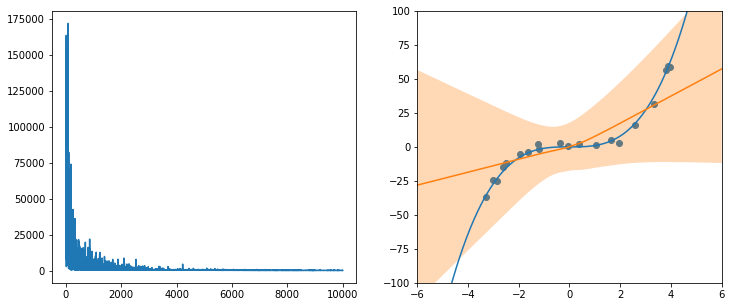

In [32]:
train(unknown_scale_bnn)

In [33]:
expected_scale(unknown_scale_bnn)

tensor(127.2362, grad_fn=<DivBackward0>)

In [56]:
unknown_scale_mcmc_bnn = ezbnn.bnn.MCMC_BNN(make_net(), prior, unknown_scale_obs_model,
                                            # partial(HMC, step_size=1e-3, num_steps=25, target_accept_prob=0.7))
                                            partial(NUTS, step_size=4e-3, max_tree_depth=5, target_accept_prob=0.6))

In [57]:
unknown_scale_mcmc_bnn.fit(make_loader(train_x, train_y, TRAIN_BATCH_SIZE), 5000, warmup_steps=2500)

Sample: 100%|██████████| 7500/7500 [17:35,  7.10it/s, step size=1.54e-01, acc. prob=0.705]


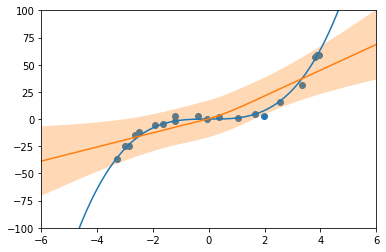

In [58]:
plot(*map(torch.squeeze, unknown_scale_mcmc_bnn.predict(test_x, num_predictions=250)))

In [42]:
unknown_scale_mcmc_bnn._mcmc.get_samples()["observation_model._scale"].mean()

tensor(10.5790)

In [43]:
known_scale_obs_model = ezbnn.observation_models.HomoskedasticGaussian(dataset_size=TRAIN_SIZE, scale=3.)
known_scale_bnn = ezbnn.SupervisedBNN(make_net(), prior, known_scale_obs_model, net_guide)

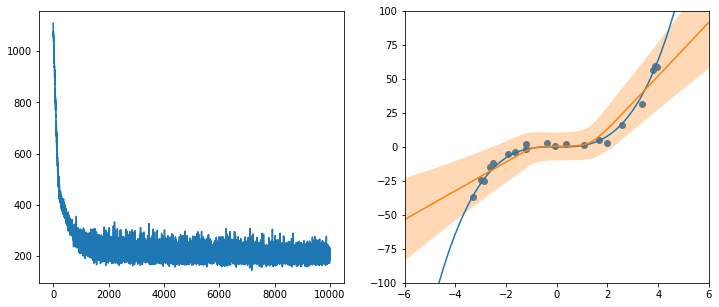

In [44]:
train(known_scale_bnn)

In [51]:
known_scale_mcmc_bnn = ezbnn.bnn.MCMC_BNN(make_net(), prior, known_scale_obs_model,
                                          # partial(HMC, step_size=1e-3, num_steps=25, target_accept_prob=0.7))
                                          partial(NUTS, step_size=4e-3, max_tree_depth=5, target_accept_prob=0.7))

In [52]:
known_scale_mcmc_bnn.fit(make_loader(train_x, train_y, TRAIN_BATCH_SIZE), 5000, warmup_steps=2500)

Sample: 100%|██████████| 7500/7500 [17:50,  7.00it/s, step size=3.21e-02, acc. prob=0.841]


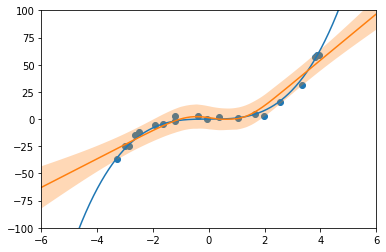

In [53]:
plot(*map(torch.squeeze, known_scale_mcmc_bnn.predict(test_x, num_predictions=20)))

In [59]:
def make_model(known_noise=True):
    def model(x, y=None):
        w0 = pyro.sample("0.weight", dist.Normal(torch.zeros(NUM_HIDDEN, 1), torch.ones(NUM_HIDDEN, 1)).to_event(2))
        b0 = pyro.sample("0.bias", dist.Normal(torch.zeros(NUM_HIDDEN), torch.ones(NUM_HIDDEN)).to_event(1))
        a = F.relu(F.linear(x, w0, b0))
        w1 = pyro.sample("2.weight", dist.Normal(torch.zeros(1, NUM_HIDDEN), torch.ones(1, NUM_HIDDEN)).to_event(2))
        b1 = pyro.sample("2.bias", dist.Normal(torch.zeros(1), torch.ones(1)).to_event(1))
        o = F.linear(a, w1, b1)

        if known_noise:
            noise_scale = NOISE_SCALE
        else:
            noise_scale = pyro.sample("noise_scale", dist.InverseGamma(2, 3))
        with pyro.plate("data"):
            pyro.sample("observation_model.obs", dist.Normal(o, noise_scale).to_event(1), obs=y)
            
        return o
    return model

In [60]:
known_noise_model = make_model(known_noise=True)

In [63]:
# kernel = HMC(known_noise_model, step_size=1e-2, num_steps=25, target_accept_prob=0.7)
kernel = NUTS(known_noise_model, step_size=1e-3, max_tree_depth=5, target_accept_prob=0.65)

In [64]:
mcmc = MCMC(kernel, 10000, warmup_steps=5000)
mcmc.run(train_x, train_y)

Sample: 100%|██████████| 15000/15000 [25:19,  9.87it/s, step size=3.53e-02, acc. prob=0.815]


In [65]:
preds = []
num_samples = 250
samples = mcmc.get_samples()
for i in range(0, mcmc.num_samples, mcmc.num_samples // num_samples):
    c = {k: v[i] for k, v in samples.items()}
    preds.append(poutine.condition(known_noise_model, c)(test_x))
predictions = torch.stack(preds).squeeze(-1)

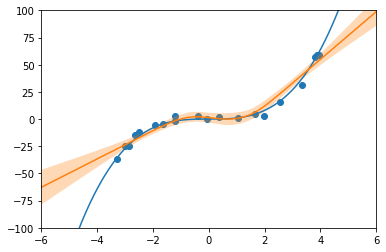

In [66]:
plot(predictions.mean(0), predictions.std(0))

In [ ]:
bnn_tr = poutine.trace(known_scale_bnn.model).get_trace(train_x, train_y)
mod_tr = poutine.trace(known_noise_model).get_trace(train_x, train_y)
rep_bnn_tr = poutine.trace(poutine.replay(known_scale_bnn.model, mod_tr)).get_trace(train_x, train_y)
rep_mod_tr = poutine.trace(poutine.replay(known_noise_model, bnn_tr)).get_trace(train_x, train_y)

In [21]:
bnn_tr.log_prob_sum(), rep_mod_tr.log_prob_sum()

(tensor(-1928.8116), tensor(-1928.8116))

In [22]:
mod_tr.log_prob_sum(), rep_bnn_tr.log_prob_sum()

(tensor(-1141.0433), tensor(-1141.0433))

In [23]:
bnn_tr.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT', 'type': 'args', 'args': (tensor([[-2.5035],
                        [ 3.9495],
                        [ 1.9691],
                        [ 1.6527],
                        [ 3.8883],
                        [ 3.3426],
                        [-1.2288],
                        [-0.3763],
                        [-2.8682],
                        [-1.6479],
                        [-1.9405],
                        [-0.0784],
                        [ 0.3684],
                        [ 1.0590],
                        [ 2.5669],
                        [ 3.8022],
                        [-2.6407],
                        [-3.0021],
                        [-1.2015],
                        [-3.3046]]), tensor([[-12.0063],
                        [ 58.8184],
                        [  2.5255],
                        [  4.9247],
                        [ 59.3144],
                        [ 31.5725],
                        [  2.425

In [24]:
rep_mod_tr.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT', 'type': 'args', 'args': (tensor([[-2.5035],
                        [ 3.9495],
                        [ 1.9691],
                        [ 1.6527],
                        [ 3.8883],
                        [ 3.3426],
                        [-1.2288],
                        [-0.3763],
                        [-2.8682],
                        [-1.6479],
                        [-1.9405],
                        [-0.0784],
                        [ 0.3684],
                        [ 1.0590],
                        [ 2.5669],
                        [ 3.8022],
                        [-2.6407],
                        [-3.0021],
                        [-1.2015],
                        [-3.3046]]), tensor([[-12.0063],
                        [ 58.8184],
                        [  2.5255],
                        [  4.9247],
                        [ 59.3144],
                        [ 31.5725],
                        [  2.425

In [25]:
bnn_tr.nodes["observation_model.obs"]["fn"].base_dist.base_dist

AttributeError: 'Normal' object has no attribute 'base_dist'

Warmup:   0%|          | 162/75000 [00:19, 98.10it/s, step size=1.48e-01, acc. prob=0.675]

In [97]:
rep_mod_tr.nodes["observation_model.obs"]["fn"].base_dist

Normal(loc: torch.Size([20, 1]), scale: torch.Size([20, 1]))